# Text mining & Search Project

### Università degli Studi di Milano-Bicocca  2020/2021

**Luzzi Federico** 816753 **Peracchi Marco** 800578

# Feature extraction

In this notebook feature extraction is implemented in order to generate useful information to the classifers.

In [1]:
import nltk
import re
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # doc2vec
import pandas as pd
import numpy as np
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier

In [3]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import seaborn as sns
from code.utils import c_matrix
from code.process_text import processing # preprocessing functions
from code.features import *

In [4]:
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
if 'processed_data.csv' not in os.listdir('data'):
    print("!!! ERROR !!!\n --- Before this, execute 02-Text_Processing_Representation Notebook ---")
else:
    df = pd.read_csv("data/processed_data.csv", sep = ",")
    print("Load & preprocessing --- DONE")

Load & preprocessing --- DONE


In [6]:
# drop tweet list na 
df["tweet_list"] = df["tweet_clean"].str.split(" ").tolist()
df.dropna(inplace = True)
df = df.reset_index(drop = True)# drop 2 NA because tweet is empty

### Sentiment Analysis

In [7]:
sentiments = []
sentiment_analyzer = VS()
for tweet in df['tweet_clean']:
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiments.append(sentiment)

In [8]:
neg = []
neu = []
pos = []
compound = []
for sentiment in sentiments:
    neg.append(sentiment['neg'])
    neu.append(sentiment['neu'])
    pos.append(sentiment['pos'])
    compound.append(sentiment['compound']) 

# save in dataframe  
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['compound'] = compound

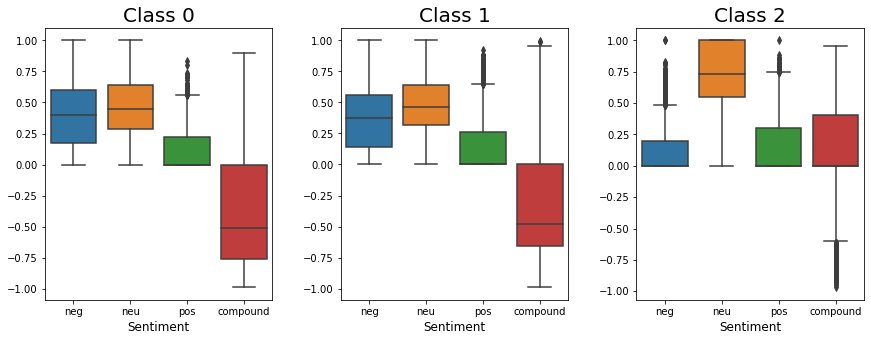

In [9]:
selected_columns = ["neg", "neu", "pos", "compound"]

fig, axs = plt.subplots(ncols = 3, figsize=(13,5))
for i in range(3):
    sns.boxplot(x="variable", y="value", data=pd.melt(df[df['class'] == i][selected_columns]), ax = axs[i])
    axs[i].set_title(f"Class {i}", size = 20)
    axs[i].set_xlabel("Sentiment", size = 12)
    axs[i].set_ylabel("")
plt.subplots_adjust(right = 1, wspace = 0.3)

### Retweet

In [10]:
def retweet(text):
    text = preprocessing(text)
    text_tokenized = tokenization(text)
    flag = 0
    for token in text_tokenized:
        if token == "rt":
            flag = 1
    return flag

In [11]:
df["rt"] = df["tweet"].apply(lambda x : retweet(x))

In [12]:
df["rt"].value_counts()

0    17624
1     7157
Name: rt, dtype: int64

### Tweet's length

In [13]:
def tweet_length(text_clean):
    return len(text_clean)

In [14]:
df["len"] = df["tweet_clean"].apply(lambda x : tweet_length(x))

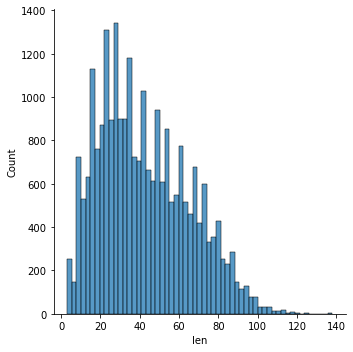

In [15]:
sns.displot(df, x="len")

### Tag's people

In [16]:
def reply_tweet(text):
    if re.search("@\w+", text):
        return 1
    else:
        return 0

In [17]:
df["num_rep"] = df["tweet"].apply(lambda x : reply_tweet(x))

In [18]:
df["num_rep"].value_counts()

1    14187
0    10594
Name: num_rep, dtype: int64

### Number of exclamation points

In [19]:
def exclamation(text):
    return len(re.findall("!", text))

In [20]:
df["num_exc"] = df["tweet"].apply(lambda x : exclamation(x))

In [21]:
df["num_exc"].value_counts()

0     22373
1      1514
2       430
3       257
4        90
5        43
6        27
7        16
9         7
8         6
11        5
10        3
12        3
13        2
35        1
19        1
24        1
25        1
14        1
Name: num_exc, dtype: int64

### Number of emoji

In [22]:
def emoji(text):
    return len(re.findall("&#1\d+", text))

In [23]:
df["emoji"] = df["tweet"].apply(lambda x : emoji(x))

In [24]:
df["emoji"].value_counts(bins = 5)

(-0.077, 15.2]    24756
(15.2, 30.4]         17
(45.6, 60.8]          3
(60.8, 76.0]          3
(30.4, 45.6]          2
Name: emoji, dtype: int64

## Output

In [25]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_clean,tweet_list,neg,neu,pos,compound,rt,len,num_rep,num_exc,emoji
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...,"[woman, shouldnt, complain, cleaning, house, m...",0.000,0.791,0.209,0.2755,1,60,1,3,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",0.259,0.741,0.000,-0.5423,1,49,1,7,0
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confuse shit,"[dawg, ever, fuck, bitch, start, cry, confuse,...",0.841,0.159,0.000,-0.9423,1,43,1,11,0
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny,"[look, like, tranny]",0.000,0.444,0.556,0.3612,1,16,1,9,0
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch tell ya,"[shit, hear, might, true, might, faker, bitch,...",0.457,0.370,0.173,-0.6808,1,46,1,13,0


In [26]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet', 'tweet_clean', 'tweet_list', 'neg', 'neu', 'pos', 'compound',
       'rt', 'len', 'num_rep', 'num_exc', 'emoji'],
      dtype='object')

In [27]:
df.to_csv('data/featured_data.csv', index = False)